In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import plotly_express as px
import plotly.graph_objects as go
import os

pal=sns.color_palette("plasma_r", 70).as_hex()[2:]
temp = {
    'layout': go.Layout(font={'family': "Franklin Gothic", 'size': 12}, width=800)
}
colors=px.colors.qualitative.Plotly
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows', 50)


In [2]:
input_file = 'data/data_new/std_a5/std_a5.csv' # 文件输入路径
output_file = 'data/TN_NH3_N2O_0531' # 文件输出路径
os.makedirs(output_file, exist_ok=True)

use_norm = False # 是否使用归一化
use_mean_encodeing = False # 使用平均数编码
missing_rate = 0.7 # 筛选缺失值的比例阈值


# 这一块自己定义
geograpy_factors = ['Longitude (E)', 'Latitude (N)']

# 类别特征
catetory_factors = ['Material_Main', 'Material_2', 'Material_3', 'Additive Species', 'Additive_1','Additive_2', 'Additive_3', 'Method', 'M1_isEnclosed', 'M2_isTurning', 'M3_isForce aeration', 'M4_isVessel', 'M5_isReactor', 'V1_Ventilation Type', 'V6_Extra']
# catetory_factors = ['Crop type']

# 数值特征
# numeric_factors = ['Application Rate (%DW)', 'Initial Moisture Content (%)', 'Initial pH','Initial TN (%)','Initial TC (%)','Initial C/N (%)', 'Initial EC (ms/cm)', 'Initial GI (%)', 'Initial FW (kg)', 'Initial DW (kg)', 'Initial NO2-N (g/kg)', 'Initial NH3-N (g/kg)', 'Final Moisture Content (%)', 'Final pH', 'Final TN (%)', 'Final TC (%)', 'Final C/N (%)', 'Final EC (ms/cm)', 'Final GI (%)', 'Final FW (kg)', 'Final DW (kg)', 'Final NH3-N (g/kg)', 'Final NO2-N (g/kg)', 'Period (d)', 'Compost volume (m3)', 'Initial density (kg/L)', 'Turning times', 'V2_Ventilation Interval (min)', 'V3_Ventilation Duration (min)', 'V4_Ventilation Day', 'V5_Ventilation rate (L/min/kg iniDW)']
numeric_factors = ['Application Rate (%DW)', 'Initial Moisture Content (%)', 'Initial pH','Initial TN (%)','Initial TC (%)','Initial C/N (%)', 'Initial EC (ms/cm)', 'Initial GI (%)', 'Initial FW (kg)', 'Initial DW (kg)', 'Initial NO2-N (g/kg)', 'Initial NH3-N (g/kg)', 'Period (d)', 'Compost volume (m3)', 'Initial density (kg/L)', 'Turning times', 'V2_Ventilation Interval (min)', 'V3_Ventilation Duration (min)', 'V4_Ventilation Day', 'V5_Ventilation rate (L/min/kg iniDW)']
# numeric_factors = ['Sand (%)', 'Silt (%)', 'Clay (%)', 'SOC (%)', 'TN (%)', 'C/N', 'pH', 'BD', 'CEC', 'N application', 'BNE', 'MAT (°C)', 'MAP (mm)']

# 要预测的目标
target = ['TN loss (%)', 'NH3-N (g)', 'N2O-N (g)', 'NH3-N loss (%)', 'N2O-N loss (%)', 'TC loss (%)', 'CH4-C (g)', 'CO2-C (g)', 'CH4-C loss (%)', 'CO2-C loss (%)']
# target = ['EF %', 'LN(EF)', 'LNR(N2O)', 'N2O rate(kg N ha-1 y-1)']

In [3]:
col = catetory_factors + numeric_factors + target
len(col)

45

In [4]:
if 'csv' in input_file:
    data_all = pd.read_csv(input_file)[col]
else:
    data_all = pd.read_excel(input_file)[col]
# # 去除所有单元格左右两边的空格
data_all = data_all.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
nan_list = ['nan', 'Nan', 'NaN', 'NAN', 'None', 'not specified']
data_all.replace('-', 0, inplace=True)
data_all.replace(nan_list, np.nan, inplace=True)
# for fea in numeric_factors:
#     try:
#         data_all[fea].apply(lambda x: int(x) if x not in nan_list else x)
#     except Exception as e:
#         print(e, fea)

In [5]:
data_all

,Material_Main,Material_2,Material_3,Additive Species,Additive_1,Additive_2,Additive_3,Method,M1_isEnclosed,M2_isTurning,M3_isForce aeration,M4_isVessel,M5_isReactor,V1_Ventilation Type,V6_Extra,Application Rate (%DW),Initial Moisture Content (%),Initial pH,Initial TN (%),Initial TC (%),Initial C/N (%),Initial EC (ms/cm),Initial GI (%),Initial FW (kg),Initial DW (kg),Initial NO2-N (g/kg),Initial NH3-N (g/kg),Period (d),Compost volume (m3),Initial density (kg/L),Turning times,V2_Ventilation Interval (min),V3_Ventilation Duration (min),V4_Ventilation Day,V5_Ventilation rate (L/min/kg iniDW),TN loss (%),NH3-N (g),N2O-N (g),NH3-N loss (%),N2O-N loss (%),TC loss (%),CH4-C (g),CO2-C (g),CH4-C loss (%),CO2-C loss (%)
0,Swine manure,Corn stalk,0,NaN,0,0,0,Reactor,1,1,1,1,1,Continuous,0,0.0,65.00,7.60664,2.66000,39.900000,15.000000,3.113100,38.0000,21.428571,7.5000,0.175751,6.77859,26.0,0.050000,0.532000,2,0,0,26,0.57,35.0000,44.579706,NaN,28.000000,NaN,50.00,NaN,NaN,NaN,NaN
1,Swine manure,Corn stalk,0,Chemical,Mg(OH)?,H?PO?,0,Reactor,1,1,1,1,1,Continuous,0,3.8,65.00,7.41084,2.66000,39.900000,15.000000,2.845240,43.0000,21.428571,7.5000,0.037264,8.11588,26.0,0.050000,0.532000,2,0,0,26,0.57,12.0000,15.483176,NaN,9.000000,NaN,53.00,NaN,NaN,NaN,NaN
2,Swine manure,Corn stalk,0,Chemical,Mg(OH)?,H?PO?,0,Reactor,1,1,1,1,1,Continuous,0,7.3,65.00,6.61538,2.66000,39.900000,15.000000,2.238100,42.0000,21.428571,7.5000,0.052280,8.16937,26.0,0.050000,0.532000,2,0,0,26,0.57,5.0000,6.177805,NaN,4.000000,NaN,55.00,NaN,NaN,NaN,NaN
3,Swine manure,Corn stalk,0,Chemical,Mg(OH)?,H?PO?,0,Reactor,1,1,1,1,1,Continuous,0,8.9,65.00,6.40734,2.66000,39.900000,15.000000,2.458330,44.0000,21.428571,7.5000,0.025584,8.82914,26.0,0.050000,0.532000,2,0,0,26,0.57,1.0000,1.328378,NaN,0.500000,NaN,43.00,NaN,NaN,NaN,NaN
4,Cow manure,Sawdust,0,NaN,0,0,0,Reactor,1,1,1,1,1,Continuous,0,0.0,61.70,7.87000,0.98400,50.600000,51.422764,6.000000,NaN,1.100000,0.4213,0.031200,1.07000,14.0,0.004000,0.275000,2,0,0,14,0.1,0.0000,0.281486,NaN,6.790000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,Cow manure,Rice straw,0,NaN,0,0,0,Static,0,0,0,1,0,NaN,0,0.0,76.28,NaN,4.33000,78.270000,18.076212,NaN,NaN,10.000000,2.3720,NaN,NaN,49.0,0.013791,0.725111,0,0,0,0,0,NaN,0.015373,0.033661,0.149681,0.327735,NaN,4.50087,21.121582,2.4243,11.376703
713,Digestate,Corn stalk,0,NaN,0,0,0,Turning,1,1,0,1,0,NaN,0,0.0,65.00,7.63760,1.33073,39.535190,29.709400,0.707592,50.3571,50.000000,17.5000,NaN,NaN,40.0,0.200000,0.250000,9,0,0,0,0,29.8437,NaN,NaN,NaN,NaN,55.81,NaN,NaN,NaN,NaN
714,Digestate,Corn stalk,0,Biological,Microbiological agent,0,0,Turning,1,1,0,1,0,NaN,0,1.0,65.00,7.74491,1.34581,40.167718,29.846500,0.758007,52.3810,50.000000,17.5000,NaN,NaN,40.0,0.200000,0.250000,9,0,0,0,0,21.0500,NaN,NaN,NaN,NaN,54.13,NaN,NaN,NaN,NaN
715,Digestate,Corn stalk,0,Physical,Biochar,0,0,Turning,1,1,0,1,0,NaN,0,5.0,65.00,7.65293,1.24777,41.277604,33.081100,0.784698,49.7619,50.000000,17.5000,NaN,NaN,40.0,0.200000,0.250000,9,0,0,0,0,25.7031,NaN,NaN,NaN,NaN,52.50,NaN,NaN,NaN,NaN


In [6]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Material_Main                         714 non-null    object 
 1   Material_2                            717 non-null    object 
 2   Material_3                            712 non-null    object 
 3   Additive Species                      412 non-null    object 
 4   Additive_1                            716 non-null    object 
 5   Additive_2                            716 non-null    object 
 6   Additive_3                            716 non-null    object 
 7   Method                                717 non-null    object 
 8   M1_isEnclosed                         717 non-null    int64  
 9   M2_isTurning                          717 non-null    int64  
 10  M3_isForce aeration                   717 non-null    int64  
 11  M4_isVessel        

In [7]:
# 初步探查每个字段的含义
columns_all = data_all.columns.tolist()
print(columns_all)
print(len(columns_all))

['Material_Main', 'Material_2', 'Material_3', 'Additive Species', 'Additive_1', 'Additive_2', 'Additive_3', 'Method', 'M1_isEnclosed', 'M2_isTurning', 'M3_isForce aeration', 'M4_isVessel', 'M5_isReactor', 'V1_Ventilation Type', 'V6_Extra', 'Application Rate (%DW)', 'Initial Moisture Content (%)', 'Initial pH', 'Initial TN (%)', 'Initial TC (%)', 'Initial C/N (%)', 'Initial EC (ms/cm)', 'Initial GI (%)', 'Initial FW (kg)', 'Initial DW (kg)', 'Initial NO2-N (g/kg)', 'Initial NH3-N (g/kg)', 'Period (d)', 'Compost volume (m3)', 'Initial density (kg/L)', 'Turning times', 'V2_Ventilation Interval (min)', 'V3_Ventilation Duration (min)', 'V4_Ventilation Day', 'V5_Ventilation rate (L/min/kg iniDW)', 'TN loss (%)', 'NH3-N (g)', 'N2O-N (g)', 'NH3-N loss (%)', 'N2O-N loss (%)', 'TC loss (%)', 'CH4-C (g)', 'CO2-C (g)', 'CH4-C loss (%)', 'CO2-C loss (%)']
45


In [8]:
data_all['V2_Ventilation Interval (min)'].unique()

array(['0', '720', '20', 0, nan, '240', '10', '40', '30', '480', '360',
       '690', '5', '60', '120', '1410'], dtype=object)

In [9]:
for col in data_all.columns.to_list():
    data_all[col] = data_all[col].astype(str)
for col in numeric_factors:
    data_all[col] = pd.to_numeric(data_all[col], errors='coerce')
for col in target:
    data_all[col] = pd.to_numeric(data_all[col], errors='coerce')

In [10]:
input_cols = catetory_factors + numeric_factors
all_cols = input_cols + target
data_all = data_all[all_cols]
print(data_all.shape)
# 观察有没有异常值
data_all.describe()

(717, 45)


,Application Rate (%DW),Initial Moisture Content (%),Initial pH,Initial TN (%),Initial TC (%),Initial C/N (%),Initial EC (ms/cm),Initial GI (%),Initial FW (kg),Initial DW (kg),Initial NO2-N (g/kg),Initial NH3-N (g/kg),Period (d),Compost volume (m3),Initial density (kg/L),Turning times,V2_Ventilation Interval (min),V3_Ventilation Duration (min),V4_Ventilation Day,V5_Ventilation rate (L/min/kg iniDW),TN loss (%),NH3-N (g),N2O-N (g),NH3-N loss (%),N2O-N loss (%),TC loss (%),CH4-C (g),CO2-C (g),CH4-C loss (%),CO2-C loss (%)
count,659.000000,591.000000,474.000000,538.000000,434.000000,530.000000,194.000000,201.000000,339.000000,304.000000,269.000000,411.000000,706.000000,629.000000,403.000000,666.000000,686.000000,686.000000,693.000000,570.000000,409.000000,274.000000,104.000000,355.000000,203.000000,189.000000,80.000000,162.000000,139.000000,81.000000
mean,6.414309,63.268867,7.462381,2.163171,39.313264,21.015546,3.658252,26.960715,2160.680220,711.736971,1.550852,3.397666,47.165722,1.519193,2.202460,6.888889,41.851312,8.676749,25.828283,2.043063,27.047629,769.280478,156.994751,13.990513,1.422044,47.474209,1664.493292,11496.558057,0.929089,22.997907
std,10.734737,8.133148,1.088237,0.940359,11.929772,8.094595,2.948250,20.474555,17891.602695,7474.902989,7.652374,3.763537,28.573902,10.294733,25.183744,13.990533,146.655407,66.378485,24.146255,5.704827,16.249154,6146.311913,977.213810,10.855968,2.146394,16.125607,6051.159896,44916.869954,1.506304,13.979704
min,0.000000,35.100000,3.510000,0.680000,16.710000,4.640000,0.311927,0.000000,0.054545,0.028000,0.000000,0.007197,6.000000,0.000250,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009267,0.002100,0.001334,0.002500,8.900000,0.004400,3.172582,0.000897,1.900000
25%,0.000000,60.000000,6.800000,1.600000,33.784925,14.853088,1.746025,6.176470,8.096900,1.450400,0.043521,0.952653,28.000000,0.030000,0.268667,0.000000,0.000000,0.000000,0.000000,0.000000,15.500637,0.600750,0.035392,4.732366,0.170472,36.770000,0.093650,22.769583,0.153908,11.893500
50%,1.377410,64.200000,7.556925,2.039745,38.494850,20.000000,2.611880,27.401500,40.000000,11.845000,0.121019,2.036360,40.000000,0.100000,0.363503,5.000000,0.000000,0.000000,27.000000,0.176922,24.932449,4.300000,0.675794,12.860000,0.790000,50.260000,3.615772,221.025909,0.300000,17.041400
75%,9.995000,68.800000,8.103022,2.460000,44.146880,25.790933,4.847500,41.006100,127.310000,40.344000,0.370000,4.747330,56.000000,0.300000,0.500000,9.000000,0.000000,0.000000,37.000000,0.660000,36.400000,21.343879,12.898094,20.313650,1.500000,58.570000,65.531813,1174.337449,0.900000,35.380000
max,122.000000,84.740000,12.064700,8.502000,196.750000,51.422764,15.800000,96.279100,258000.000000,109701.600000,60.289900,28.237100,287.000000,202.500000,360.000000,180.000000,1410.000000,1200.000000,112.000000,36.666667,88.170000,83199.277440,9288.427273,52.224035,12.650633,83.520000,47137.500000,294830.000000,7.500000,60.200000


In [11]:
# 异常值处理
data_all['Initial pH'] = data_all['Initial pH'].clip(lower=3, upper=14)

### 检验异常值（三倍方差法）

In [12]:
# 利用方差检验法检查异常值
def find_outlines_by_3segama(df, fea):
    data_std = np.std(df[fea])
    data_mean = np.mean(df[fea])
    outlines_cut_off = data_std * 3
    lower_rule = data_mean - outlines_cut_off
    upper_rule = data_mean + outlines_cut_off
    # 新建列判断哪个具有异常值
    try:
        df[fea+'outlines'] = df[fea].apply(lambda x:str('error') if x>upper_rule or x<lower_rule else 'normal')
        # print('upper_rule:', upper_rule, '\nlower_rule', lower_rule, '\nfea', fea)
    except Exception as e:
        print('出现错误:', e)
        print('upper_rule:', upper_rule, '\nlower_rule', lower_rule, '\nfea', fea)
    
    return df

In [13]:
data_all['Turning times'].unique()

array([  2.,   7.,   6.,   5.,  12.,  21.,   0.,   9.,   3.,  nan,   4.,
         8.,   1.,  14.,  10.,  11., 180.,  24.,  54.,  25.,  37.,  15.,
        62.,  66.,  23.,  13.,  43.,  20.,  18.])

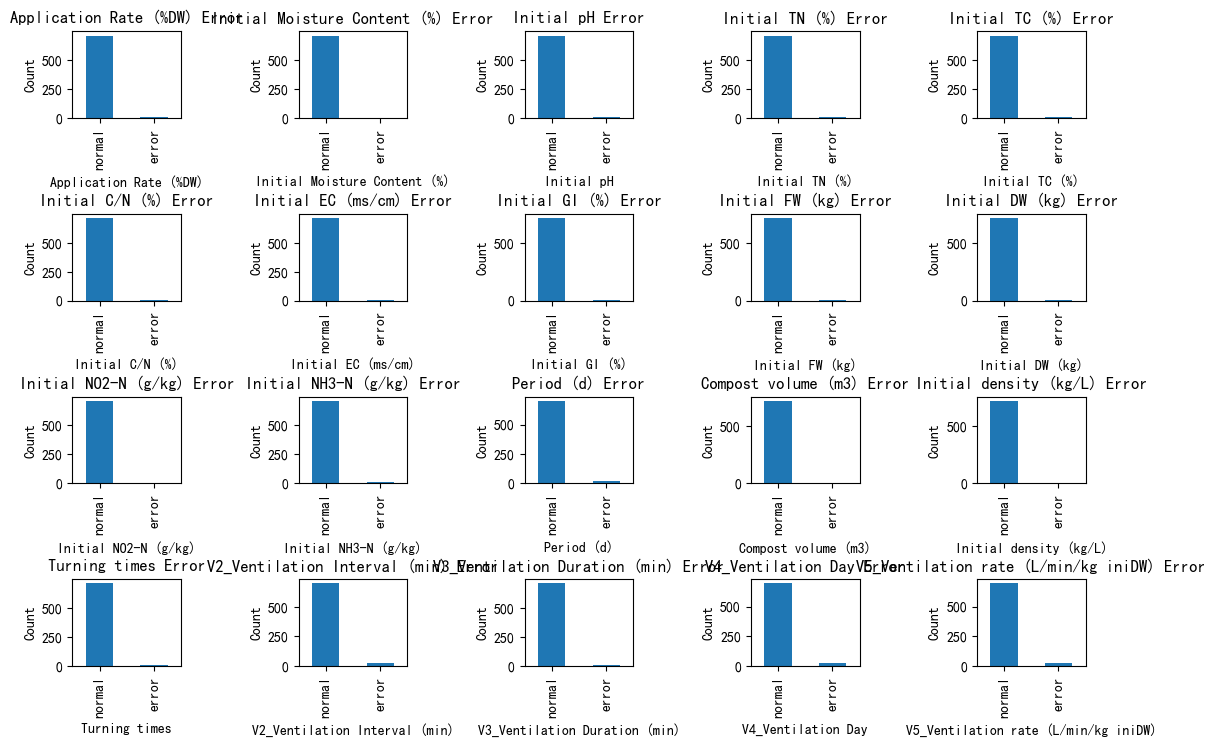

In [14]:
import math

# 查看每一列的异常值数量
error_train = data_all.copy()
# 计算要创建的子图网格的行数和列数
total_plots = len(numeric_factors)
rows = int(math.sqrt(total_plots))
cols = math.ceil(total_plots / rows)

# 创建一个包含所有子图的大图
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
fig.tight_layout(pad=5.0)  # 调整子图之间的间距
check_fea = numeric_factors
for i, fea in enumerate(check_fea):
    row, col = i // cols, i % cols
    ax = axes[row, col]
    try:
        error_train = find_outlines_by_3segama(error_train, fea)
    except:
        print(fea)
    error_train[f'{fea}outlines'].value_counts().plot(kind='bar', ax=ax)
    ax.set_title(f'{fea} Error')
    ax.set_xlabel(fea)
    ax.set_ylabel('Count')

In [15]:
# 将异常值填充为平均值
for fea in check_fea:
    condition = error_train[fea + 'outlines'] == 'error'
    mean_value = data_all[fea].mean()
    data_all.loc[condition, fea] = mean_value

In [16]:
data_all.describe()

,Application Rate (%DW),Initial Moisture Content (%),Initial pH,Initial TN (%),Initial TC (%),Initial C/N (%),Initial EC (ms/cm),Initial GI (%),Initial FW (kg),Initial DW (kg),Initial NO2-N (g/kg),Initial NH3-N (g/kg),Period (d),Compost volume (m3),Initial density (kg/L),Turning times,V2_Ventilation Interval (min),V3_Ventilation Duration (min),V4_Ventilation Day,V5_Ventilation rate (L/min/kg iniDW),TN loss (%),NH3-N (g),N2O-N (g),NH3-N loss (%),N2O-N loss (%),TC loss (%),CH4-C (g),CO2-C (g),CH4-C loss (%),CO2-C loss (%)
count,659.000000,591.000000,474.000000,538.000000,434.000000,530.000000,194.000000,201.000000,339.000000,304.000000,269.000000,411.000000,706.000000,629.000000,403.000000,666.000000,686.000000,686.000000,693.000000,570.000000,409.000000,274.000000,104.000000,355.000000,203.000000,189.000000,80.000000,162.000000,139.000000,81.000000
mean,5.657260,63.410164,7.426184,2.085790,38.322173,20.715472,3.418680,26.615847,822.395148,124.177346,0.538786,3.113614,44.793889,0.979509,0.435061,5.725392,20.260754,3.829383,23.392817,1.061041,27.047629,769.280478,156.994751,13.990513,1.422044,47.474209,1664.493292,11496.558057,0.929089,22.997907
std,8.318474,7.885941,0.979918,0.728304,7.717338,7.577809,2.413833,19.876184,2977.075994,568.829717,1.448983,3.012196,22.156331,3.291316,0.290910,6.273239,71.508056,9.731314,19.730236,2.394536,16.249154,6146.311913,977.213810,10.855968,2.146394,16.125607,6051.159896,44916.869954,1.506304,13.979704
min,0.000000,41.900000,4.280000,0.680000,16.710000,4.640000,0.311927,0.000000,0.054545,0.028000,0.000000,0.007197,6.000000,0.000250,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009267,0.002100,0.001334,0.002500,8.900000,0.004400,3.172582,0.000897,1.900000
25%,0.000000,60.000000,6.802450,1.600000,33.784925,14.853088,1.746025,6.176470,8.096900,1.450400,0.043521,0.952653,28.000000,0.030000,0.268667,0.000000,0.000000,0.000000,0.000000,0.000000,15.500637,0.600750,0.035392,4.732366,0.170472,36.770000,0.093650,22.769583,0.153908,11.893500
50%,1.377410,64.200000,7.502965,2.039745,38.494850,20.000000,2.611880,26.960715,40.000000,11.845000,0.121019,2.036360,40.000000,0.100000,0.363503,5.000000,0.000000,0.000000,25.828283,0.176922,24.932449,4.300000,0.675794,12.860000,0.790000,50.260000,3.615772,221.025909,0.300000,17.041400
75%,9.360385,68.800000,8.077298,2.400000,43.825750,25.269929,4.660000,40.833300,127.310000,40.344000,0.370000,4.468000,56.000000,0.300000,0.500000,9.000000,0.000000,0.000000,36.000000,0.660000,36.400000,21.343879,12.898094,20.313650,1.500000,58.570000,65.531813,1174.337449,0.900000,35.380000
max,38.186158,84.740000,10.700000,4.937870,59.613117,45.000000,12.200000,83.720900,20000.000000,6637.060000,10.973700,14.520000,112.000000,22.500000,2.202460,43.000000,480.000000,60.000000,76.000000,17.857143,88.170000,83199.277440,9288.427273,52.224035,12.650633,83.520000,47137.500000,294830.000000,7.500000,60.200000


In [17]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 45 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Material_Main                         717 non-null    object 
 1   Material_2                            717 non-null    object 
 2   Material_3                            717 non-null    object 
 3   Additive Species                      717 non-null    object 
 4   Additive_1                            717 non-null    object 
 5   Additive_2                            717 non-null    object 
 6   Additive_3                            717 non-null    object 
 7   Method                                717 non-null    object 
 8   M1_isEnclosed                         717 non-null    object 
 9   M2_isTurning                          717 non-null    object 
 10  M3_isForce aeration                   717 non-null    object 
 11  M4_isVessel        

In [18]:
import pandas_profiling as pp
# report = pp.ProfileReport(data_all)
# report.to_file('report.html')

In [19]:
# 生成初步分析报告
# report

### 缺失值处理

In [20]:
# 查看数据缺失值
missing = data_all.isnull().sum() / len(data_all)
missing = missing[missing>0]
missing.sort_values(inplace=True)

fig=go.Figure()
fig.add_trace(go.Bar(x=missing.index, y=missing.values,
                    hovertemplate='%{x} Missing ratio = %{y:.2f}<extra></extra>'))
fig.update_layout(template=temp,title='Missing Ration', 
                  xaxis={'title':'Average Importance','zeroline': False},
                  yaxis_showgrid=False, margin={'l': 120,'t':80},
                  height=400, width=800)


In [21]:
# 筛去缺失值大于50%的数据列
columns_nomiss = missing[missing < missing_rate].index.tolist()
columns_miss = missing[missing >= missing_rate].index.tolist()
print(f'{len(columns_miss)} is missing')
print(columns_miss)
columns_nomiss = [i for i in columns_nomiss if i not in target]

# 更新类别特征和数值特征
catetory_factors = [col for col in catetory_factors if col in columns_nomiss]
numeric_factors = [col for col in numeric_factors if col in columns_nomiss]

print('catetory_factors update',catetory_factors)
print('numeric_factors update',numeric_factors)

9 is missing
['N2O-N loss (%)', 'Initial GI (%)', 'Initial EC (ms/cm)', 'TC loss (%)', 'CO2-C (g)', 'CH4-C loss (%)', 'N2O-N (g)', 'CO2-C loss (%)', 'CH4-C (g)']
catetory_factors update []
numeric_factors update ['Application Rate (%DW)', 'Initial Moisture Content (%)', 'Initial pH', 'Initial TN (%)', 'Initial TC (%)', 'Initial C/N (%)', 'Initial FW (kg)', 'Initial DW (kg)', 'Initial NO2-N (g/kg)', 'Initial NH3-N (g/kg)', 'Period (d)', 'Compost volume (m3)', 'Initial density (kg/L)', 'Turning times', 'V2_Ventilation Interval (min)', 'V3_Ventilation Duration (min)', 'V4_Ventilation Day', 'V5_Ventilation rate (L/min/kg iniDW)']


In [22]:
columns_nomiss, len(columns_nomiss)

(['Period (d)',
  'V4_Ventilation Day',
  'V3_Ventilation Duration (min)',
  'V2_Ventilation Interval (min)',
  'Turning times',
  'Application Rate (%DW)',
  'Compost volume (m3)',
  'Initial Moisture Content (%)',
  'V5_Ventilation rate (L/min/kg iniDW)',
  'Initial TN (%)',
  'Initial C/N (%)',
  'Initial pH',
  'Initial TC (%)',
  'Initial NH3-N (g/kg)',
  'Initial density (kg/L)',
  'Initial FW (kg)',
  'Initial DW (kg)',
  'Initial NO2-N (g/kg)'],
 18)

In [23]:
data_target = data_all[target]
data_input = data_all[columns_nomiss]

In [24]:
data_input.head(3)

,Period (d),V4_Ventilation Day,V3_Ventilation Duration (min),V2_Ventilation Interval (min),Turning times,Application Rate (%DW),Compost volume (m3),Initial Moisture Content (%),V5_Ventilation rate (L/min/kg iniDW),Initial TN (%),Initial C/N (%),Initial pH,Initial TC (%),Initial NH3-N (g/kg),Initial density (kg/L),Initial FW (kg),Initial DW (kg),Initial NO2-N (g/kg)
0,26.0,26.0,0.0,0.0,2.0,0.0,0.05,65.0,0.57,2.66,15.0,7.60664,39.9,6.77859,0.532,21.428571,7.5,0.175751
1,26.0,26.0,0.0,0.0,2.0,3.8,0.05,65.0,0.57,2.66,15.0,7.41084,39.9,8.11588,0.532,21.428571,7.5,0.037264
2,26.0,26.0,0.0,0.0,2.0,7.3,0.05,65.0,0.57,2.66,15.0,6.61538,39.9,8.16937,0.532,21.428571,7.5,0.052280


In [25]:
data_target.head(3)

,TN loss (%),NH3-N (g),N2O-N (g),NH3-N loss (%),N2O-N loss (%),TC loss (%),CH4-C (g),CO2-C (g),CH4-C loss (%),CO2-C loss (%)
0,35.0,44.579706,NaN,28.0,NaN,50.0,NaN,NaN,NaN,NaN
1,12.0,15.483176,NaN,9.0,NaN,53.0,NaN,NaN,NaN,NaN
2,5.0,6.177805,NaN,4.0,NaN,55.0,NaN,NaN,NaN,NaN


In [26]:
data_all.head(3)

,Material_Main,Material_2,Material_3,Additive Species,Additive_1,Additive_2,Additive_3,Method,M1_isEnclosed,M2_isTurning,M3_isForce aeration,M4_isVessel,M5_isReactor,V1_Ventilation Type,V6_Extra,Application Rate (%DW),Initial Moisture Content (%),Initial pH,Initial TN (%),Initial TC (%),Initial C/N (%),Initial EC (ms/cm),Initial GI (%),Initial FW (kg),Initial DW (kg),Initial NO2-N (g/kg),Initial NH3-N (g/kg),Period (d),Compost volume (m3),Initial density (kg/L),Turning times,V2_Ventilation Interval (min),V3_Ventilation Duration (min),V4_Ventilation Day,V5_Ventilation rate (L/min/kg iniDW),TN loss (%),NH3-N (g),N2O-N (g),NH3-N loss (%),N2O-N loss (%),TC loss (%),CH4-C (g),CO2-C (g),CH4-C loss (%),CO2-C loss (%)
0,Swine manure,Corn stalk,0,nan,0,0,0,Reactor,1,1,1,1,1,Continuous,0,0.0,65.0,7.60664,2.66,39.9,15.0,3.11310,38.0,21.428571,7.5,0.175751,6.77859,26.0,0.05,0.532,2.0,0.0,0.0,26.0,0.57,35.0,44.579706,NaN,28.0,NaN,50.0,NaN,NaN,NaN,NaN
1,Swine manure,Corn stalk,0,Chemical,Mg(OH)?,H?PO?,0,Reactor,1,1,1,1,1,Continuous,0,3.8,65.0,7.41084,2.66,39.9,15.0,2.84524,43.0,21.428571,7.5,0.037264,8.11588,26.0,0.05,0.532,2.0,0.0,0.0,26.0,0.57,12.0,15.483176,NaN,9.0,NaN,53.0,NaN,NaN,NaN,NaN
2,Swine manure,Corn stalk,0,Chemical,Mg(OH)?,H?PO?,0,Reactor,1,1,1,1,1,Continuous,0,7.3,65.0,6.61538,2.66,39.9,15.0,2.23810,42.0,21.428571,7.5,0.052280,8.16937,26.0,0.05,0.532,2.0,0.0,0.0,26.0,0.57,5.0,6.177805,NaN,4.0,NaN,55.0,NaN,NaN,NaN,NaN


In [27]:
# 填充缺失值
def fill_missing(df, numerical_fea):
    df[numerical_fea] = df[numerical_fea].fillna(0)
    # df[numerical_fea] = df[numerical_fea].fillna(df[numerical_fea].mean())

input_cols = data_input.columns.tolist()
fill_missing(data_input, numeric_factors)

In [28]:
data_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Period (d)                            717 non-null    float64
 1   V4_Ventilation Day                    717 non-null    float64
 2   V3_Ventilation Duration (min)         717 non-null    float64
 3   V2_Ventilation Interval (min)         717 non-null    float64
 4   Turning times                         717 non-null    float64
 5   Application Rate (%DW)                717 non-null    float64
 6   Compost volume (m3)                   717 non-null    float64
 7   Initial Moisture Content (%)          717 non-null    float64
 8   V5_Ventilation rate (L/min/kg iniDW)  717 non-null    float64
 9   Initial TN (%)                        717 non-null    float64
 10  Initial C/N (%)                       717 non-null    float64
 11  Initial pH         

In [29]:
data_input.head(3)

,Period (d),V4_Ventilation Day,V3_Ventilation Duration (min),V2_Ventilation Interval (min),Turning times,Application Rate (%DW),Compost volume (m3),Initial Moisture Content (%),V5_Ventilation rate (L/min/kg iniDW),Initial TN (%),Initial C/N (%),Initial pH,Initial TC (%),Initial NH3-N (g/kg),Initial density (kg/L),Initial FW (kg),Initial DW (kg),Initial NO2-N (g/kg)
0,26.0,26.0,0.0,0.0,2.0,0.0,0.05,65.0,0.57,2.66,15.0,7.60664,39.9,6.77859,0.532,21.428571,7.5,0.175751
1,26.0,26.0,0.0,0.0,2.0,3.8,0.05,65.0,0.57,2.66,15.0,7.41084,39.9,8.11588,0.532,21.428571,7.5,0.037264
2,26.0,26.0,0.0,0.0,2.0,7.3,0.05,65.0,0.57,2.66,15.0,6.61538,39.9,8.16937,0.532,21.428571,7.5,0.052280


In [30]:
numeric_factors

['Application Rate (%DW)',
 'Initial Moisture Content (%)',
 'Initial pH',
 'Initial TN (%)',
 'Initial TC (%)',
 'Initial C/N (%)',
 'Initial FW (kg)',
 'Initial DW (kg)',
 'Initial NO2-N (g/kg)',
 'Initial NH3-N (g/kg)',
 'Period (d)',
 'Compost volume (m3)',
 'Initial density (kg/L)',
 'Turning times',
 'V2_Ventilation Interval (min)',
 'V3_Ventilation Duration (min)',
 'V4_Ventilation Day',
 'V5_Ventilation rate (L/min/kg iniDW)']

#### 查看特征相关性

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

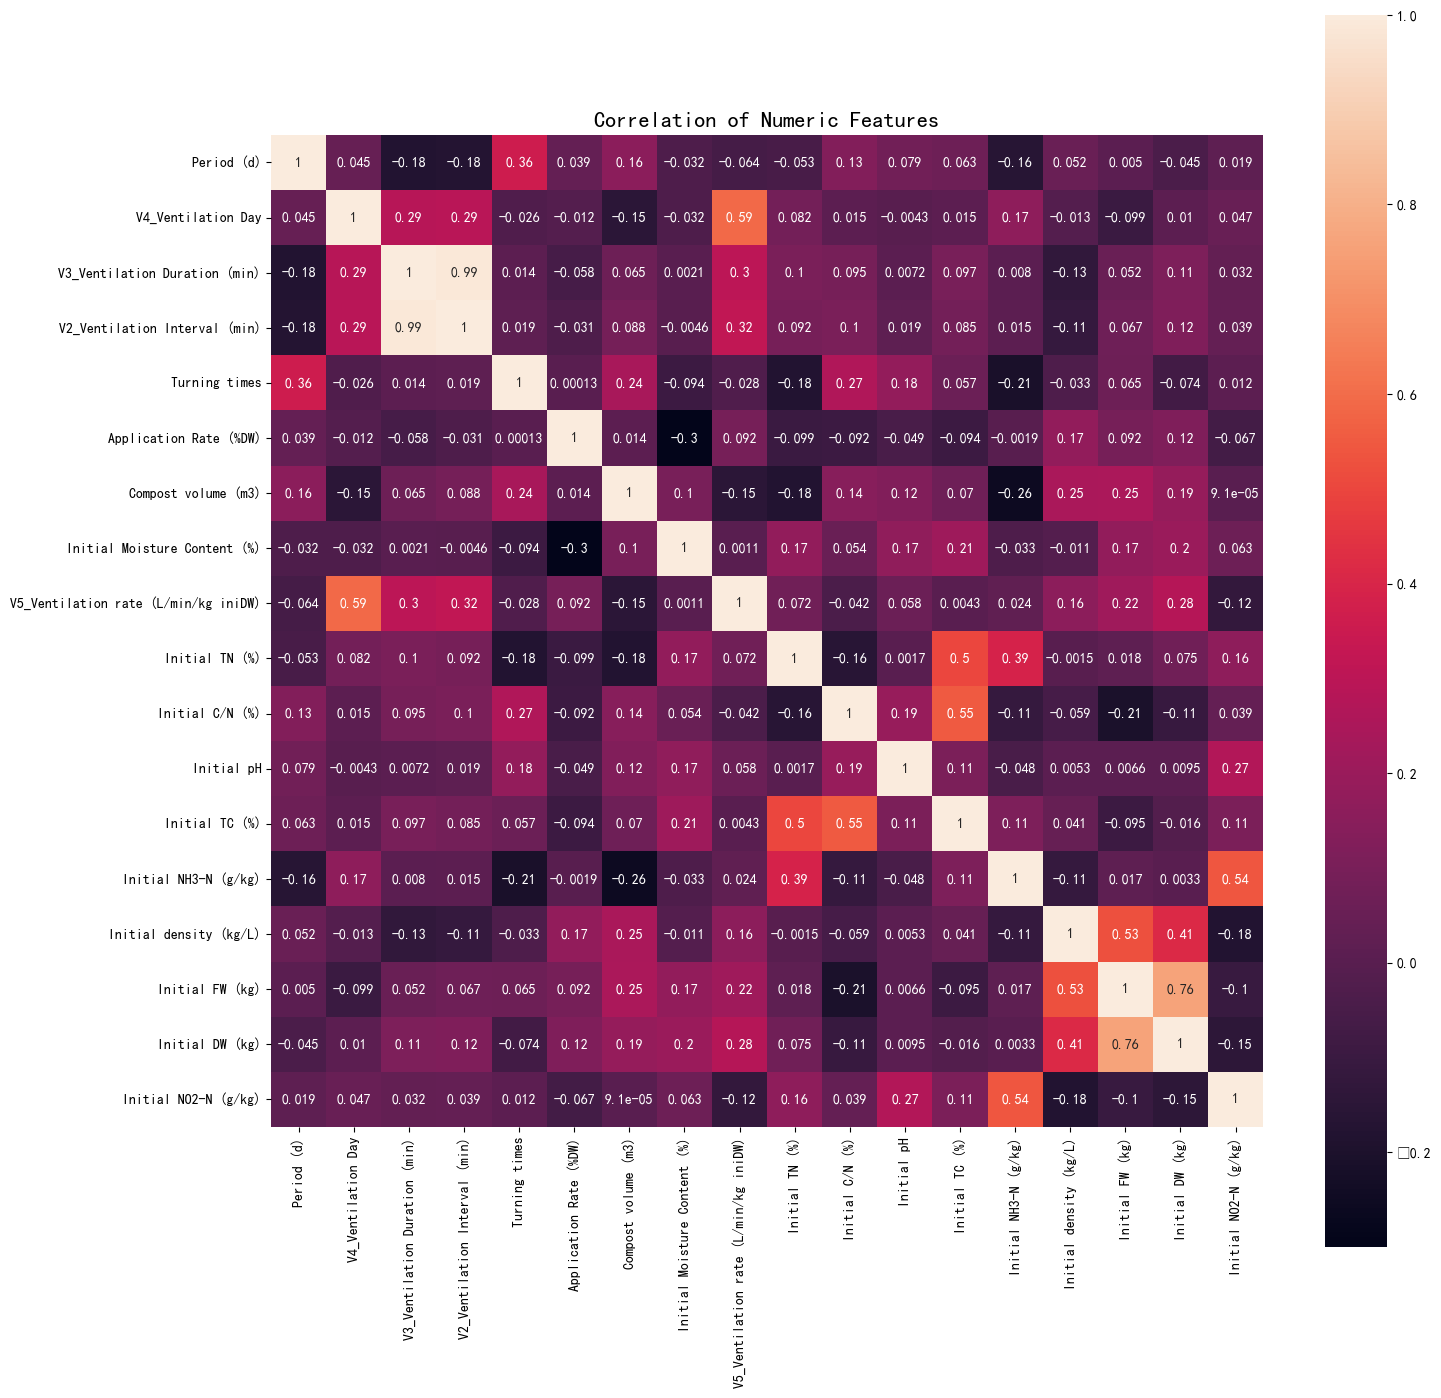

In [31]:
# 查看heatmap图
correlation_matrix = data_input[input_cols].corr(method='spearman')
f, ax = plt.subplots(figsize=(16,16))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(correlation_matrix,square=True,ax=ax,annot=True)

In [32]:
input_cols + target

['Period (d)',
 'V4_Ventilation Day',
 'V3_Ventilation Duration (min)',
 'V2_Ventilation Interval (min)',
 'Turning times',
 'Application Rate (%DW)',
 'Compost volume (m3)',
 'Initial Moisture Content (%)',
 'V5_Ventilation rate (L/min/kg iniDW)',
 'Initial TN (%)',
 'Initial C/N (%)',
 'Initial pH',
 'Initial TC (%)',
 'Initial NH3-N (g/kg)',
 'Initial density (kg/L)',
 'Initial FW (kg)',
 'Initial DW (kg)',
 'Initial NO2-N (g/kg)',
 'TN loss (%)',
 'NH3-N (g)',
 'N2O-N (g)',
 'NH3-N loss (%)',
 'N2O-N loss (%)',
 'TC loss (%)',
 'CH4-C (g)',
 'CO2-C (g)',
 'CH4-C loss (%)',
 'CO2-C loss (%)']

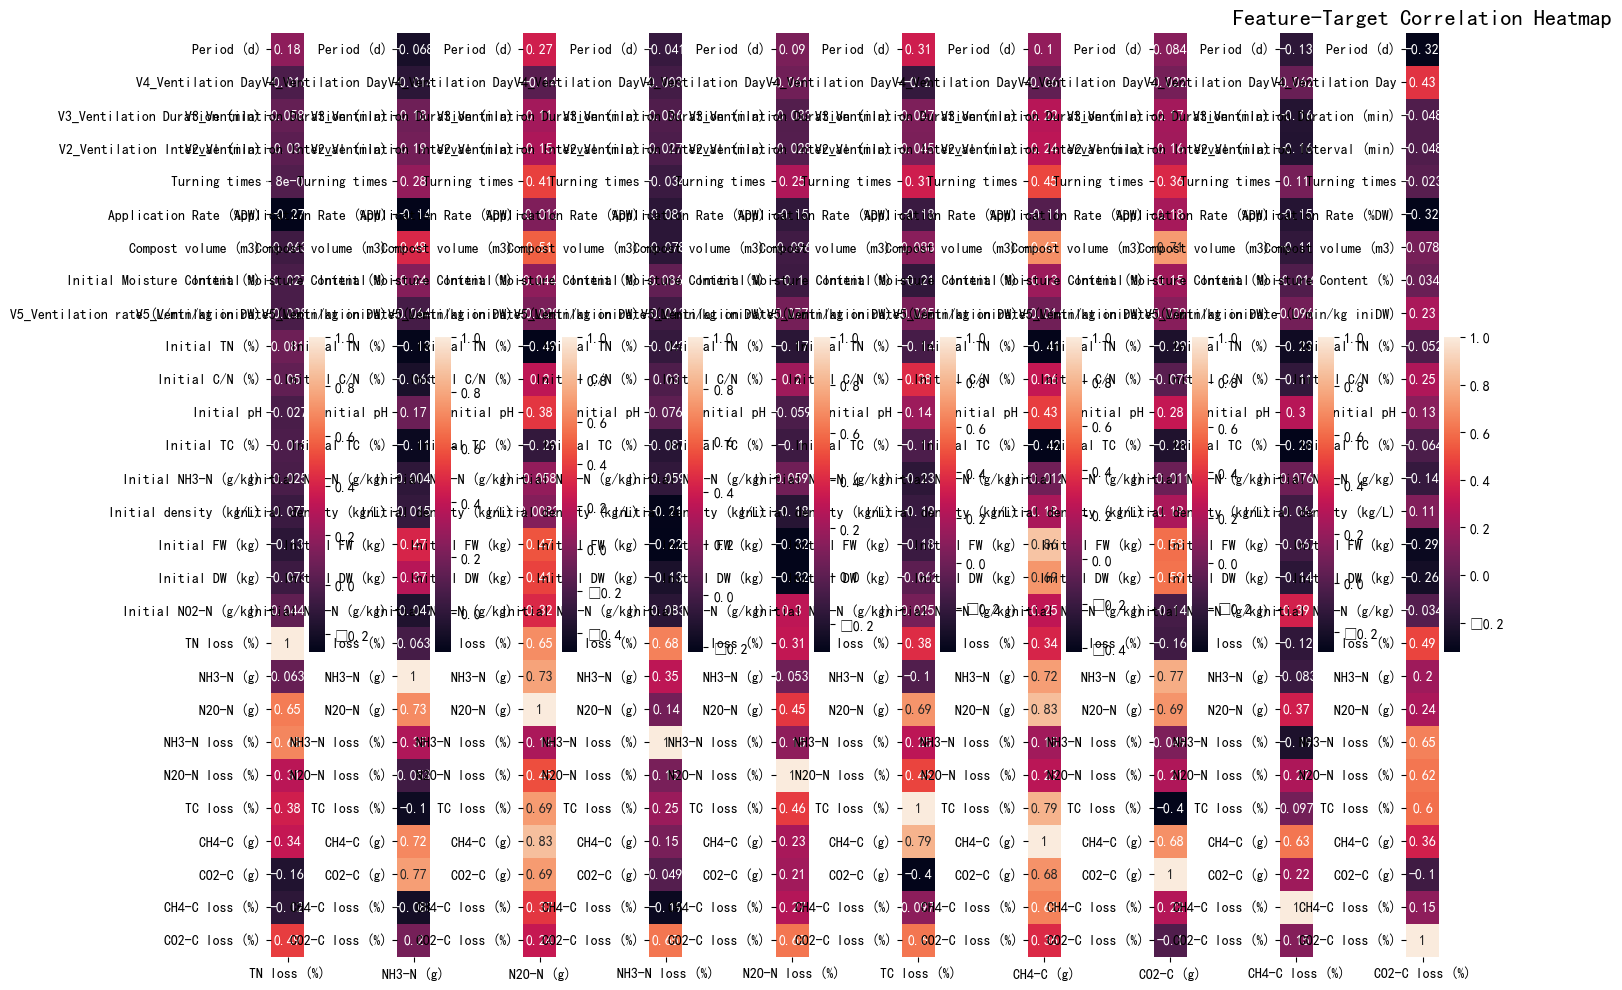

In [33]:
# 查看heatmap图
data_Xy = pd.concat([data_input, data_target], axis=1)

# 进行平均数编码的时候列名是{col}_{trg}，现在根据不同的trg，把列名弄成{col}, 创建副本

corr = data_Xy[input_cols + target].corr(method='spearman')
f, axes = plt.subplots(1, len(target), figsize=(16,12))
plt.title('Feature-Target Correlation Heatmap',y=1,size=16)
for i, trg in enumerate(target):
    sns.heatmap(corr[[trg]],square=True,ax=axes[i],annot=True)


#### 进行保存

In [34]:
data_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Period (d)                            717 non-null    float64
 1   V4_Ventilation Day                    717 non-null    float64
 2   V3_Ventilation Duration (min)         717 non-null    float64
 3   V2_Ventilation Interval (min)         717 non-null    float64
 4   Turning times                         717 non-null    float64
 5   Application Rate (%DW)                717 non-null    float64
 6   Compost volume (m3)                   717 non-null    float64
 7   Initial Moisture Content (%)          717 non-null    float64
 8   V5_Ventilation rate (L/min/kg iniDW)  717 non-null    float64
 9   Initial TN (%)                        717 non-null    float64
 10  Initial C/N (%)                       717 non-null    float64
 11  Initial pH         

In [35]:
data_input.head(3)

,Period (d),V4_Ventilation Day,V3_Ventilation Duration (min),V2_Ventilation Interval (min),Turning times,Application Rate (%DW),Compost volume (m3),Initial Moisture Content (%),V5_Ventilation rate (L/min/kg iniDW),Initial TN (%),Initial C/N (%),Initial pH,Initial TC (%),Initial NH3-N (g/kg),Initial density (kg/L),Initial FW (kg),Initial DW (kg),Initial NO2-N (g/kg)
0,26.0,26.0,0.0,0.0,2.0,0.0,0.05,65.0,0.57,2.66,15.0,7.60664,39.9,6.77859,0.532,21.428571,7.5,0.175751
1,26.0,26.0,0.0,0.0,2.0,3.8,0.05,65.0,0.57,2.66,15.0,7.41084,39.9,8.11588,0.532,21.428571,7.5,0.037264
2,26.0,26.0,0.0,0.0,2.0,7.3,0.05,65.0,0.57,2.66,15.0,6.61538,39.9,8.16937,0.532,21.428571,7.5,0.052280


In [36]:
# 归一化
def normalize_features(df, fea_columns):
    """
    基于均值和标准差进行归一化
    """
    for col in fea_columns:
        try:
            mean = df[col].mean()
            std = df[col].std()
            df[col] = (df[col] - mean) / std
        except Exception as e:
            print('normalize_features出现错误：', e)
            print(f'{col}这一列有问题')
    return df

if use_norm:
    data_all_norm = normalize_features(data_input, numeric_factors)
else:
    data_all_norm = data_input

In [37]:
#### 处理类别特征（类别数量少的直接使用序列编码，类别数量太大>20使用平均数编码）
from sklearn.preprocessing import LabelEncoder

# 按类别数量区分高类别和低类别特征
def high_or_low_category(df, columns):
    high_cat_features = []
    low_cat_features = []

    for col in columns:
        if df[col].dtype == 'object':
            unique_count = df[col].nunique()
            # 类别特征大于20认为是高基数类别特征
            if unique_count >= 20: high_cat_features.append(col)
            else: low_cat_features.append(col)
    
    return high_cat_features, low_cat_features

# 序列编码
def encode_categories(df, columns):
    dic_lst = [] # 返回映射关系的字典
    for col in columns:
        label_encoder = LabelEncoder()
        # 对类别数据进行编码
        encoded_column = label_encoder.fit_transform(df[col])
        df[col] = encoded_column
        # 返回类别到数字的映射字典
        category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        dic_lst.append(category_mapping)
    
    return dic_lst

# 平均数编码
def mean_encoding(df, cat_feature, target_feature):
    for cat in cat_feature:
        for trg in target_feature:
            try:
                # print(df.columns)
                df_nonan = df.dropna(subset=[cat, trg])
                display(df_nonan)
                mean_encoded_values = df_nonan.groupby(cat)[trg].mean()
                print(mean_encoded_values)
                df[f'{cat}_{trg}'] = df[cat].map(mean_encoded_values)
            except Exception as e:
                print('mean_encoding出现错误：', e)
                print('cat:', cat, 'trg:', trg)
    cols = [col for col in df.columns if col not in target_feature]
    return df[cols]


In [38]:
high_cat_features, low_cat_features = high_or_low_category(data_input, catetory_factors)
print('low_cat_features',low_cat_features)
print('high_cat_features',high_cat_features)


if use_mean_encodeing:
    # 是否使用平均数编码
    mapping_dict = encode_categories(data_input, low_cat_features)
    data_input = mean_encoding(pd.concat([data_input, data_target]), high_cat_features, target)
else:
    mapping_dict = encode_categories(data_input, catetory_factors)
data_input.head(3)

low_cat_features []
high_cat_features []


,Period (d),V4_Ventilation Day,V3_Ventilation Duration (min),V2_Ventilation Interval (min),Turning times,Application Rate (%DW),Compost volume (m3),Initial Moisture Content (%),V5_Ventilation rate (L/min/kg iniDW),Initial TN (%),Initial C/N (%),Initial pH,Initial TC (%),Initial NH3-N (g/kg),Initial density (kg/L),Initial FW (kg),Initial DW (kg),Initial NO2-N (g/kg)
0,26.0,26.0,0.0,0.0,2.0,0.0,0.05,65.0,0.57,2.66,15.0,7.60664,39.9,6.77859,0.532,21.428571,7.5,0.175751
1,26.0,26.0,0.0,0.0,2.0,3.8,0.05,65.0,0.57,2.66,15.0,7.41084,39.9,8.11588,0.532,21.428571,7.5,0.037264
2,26.0,26.0,0.0,0.0,2.0,7.3,0.05,65.0,0.57,2.66,15.0,6.61538,39.9,8.16937,0.532,21.428571,7.5,0.052280


In [39]:
# 直接保存以供预测
for trg in target:
    data_final = data_all_norm.copy()
    final_col = input_cols
    if use_mean_encodeing:
        for hcf in high_cat_features:
            final_col = [col for col in final_col if hcf not in col and col != f'{hcf}_{trg}']
            data_final[hcf] = data_final[f'{hcf}_{trg}']
    data_for_pre = pd.concat([data_final[final_col], data_target[trg]], axis=1)
    data_for_pre = data_for_pre.dropna(subset=[trg])
    # 在这才去类别特征处理
    if use_mean_encodeing:
        # 目前还是不使用平均数编码（因为要么高基数的输入列缺的多，要么target缺的多）
        mapping_dict = encode_categories(data_for_pre, low_cat_features)
        data_for_pre = mean_encoding(pd.concat([data_for_pre, data_target]), high_cat_features, target)
    else:
        mapping_dict = encode_categories(data_for_pre, catetory_factors)
    data_for_pre.to_csv(f'{output_file}/data_for_{trg}.csv', index=False)
